# Spiking Neural Network Classifier

**MatTheTab** : [Github](https://github.com/MatTheTab)

This notebook showcases the training processs of a Convolutional Spiking Neural Network (SNN) model using the `snntorch` library. Spiking Neural Networks are biologically inspired models that process information as discrete events or "spikes," mimicking the behavior of neurons in the brain.

The notebook showcases the model architecture, data preprocessing, training process, evaluation and visualizations of the model's performance for the CIFAR-10 dataset.


## Imports

In [1]:
! pip install snntorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 11.4 MB/s eta 0:00:00


In [2]:
# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader
from snntorch import surrogate
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.utils.data import random_split
from snntorch import functional as SF
from snntorch import utils

# Additional Imports
import snntorch as snn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np
import time
import os
from tqdm import tqdm
from IPython.display import Video

# Set the seed for reproducibility of results
torch.manual_seed(0)

## Variables Declarations

Below are variables which will later be used in the whole notebook. Some of them can be changed according to the user's needs, however it might negatively effect the training process.

In [3]:
BATCH_SIZE = 64
BETA = 0.5
SPIKE_GRAD = surrogate.fast_sigmoid(slope=25)
EPOCHS = 50
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

## Data Reading and Preprocessing

### Functions

In [4]:
def denormalize(image_tensor):
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    image_tensor = image_tensor * std[:, None, None] + mean[:, None, None]
    return image_tensor

def show_random_images(data_loader):
    images = []
    labels = []
    for image, label in data_loader:
        images.append(image[0])
        labels.append(label[0])
        if len(images) == 10:
            break

    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        label = labels[i]
        image = denormalize(images[i])
        ax = plt.subplot(1, len(images), i + 1)
        npimg = image.numpy().transpose((1, 2, 0))
        plt.imshow(npimg)
        ax.set_title(f"{classes[label]}")
        ax.axis("off")
    plt.show()


### Running Code

In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_path = './data'
train_set = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

train_size = int(0.85 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

BATCH_SIZE = 64
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 170498071/170498071 [00:18<00:00, 9163171.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
print(f"Training Set Size: {len(train_set)}")
print(f"Training Loader Size: {len(train_loader)}")
print(f"Validation Loader Size: {len(val_loader)}")
print(f"Test Set Size: {len(test_set)}")
print(f"Test Loader Size: {len(test_loader)}")

Training Set Size: 50000
Training Loader Size: 664
Validation Loader Size: 117
Test Set Size: 10000
Test Loader Size: 156


In [7]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


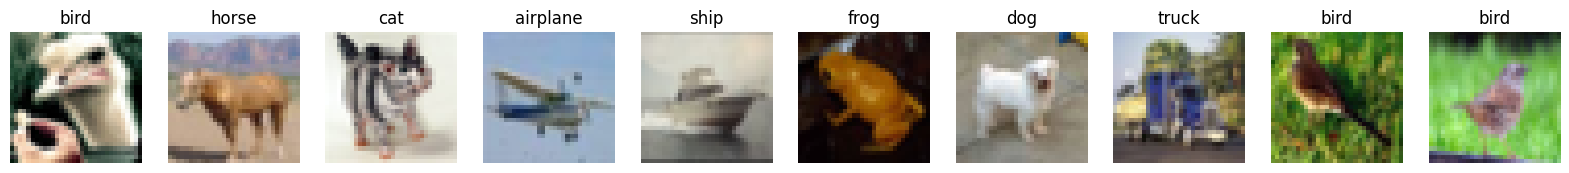

In [8]:
show_random_images(train_loader)

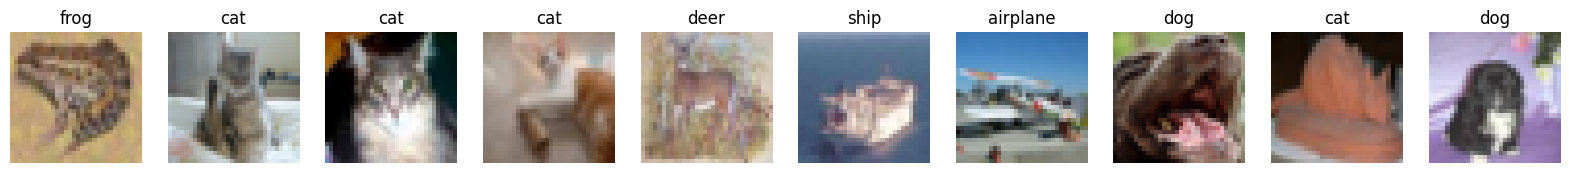

In [9]:
show_random_images(val_loader)

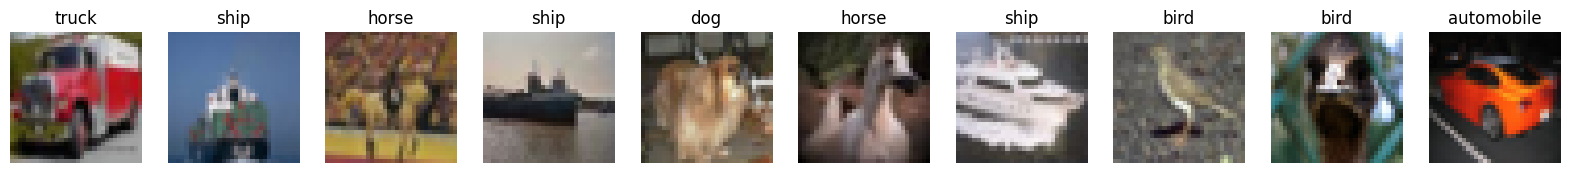

In [10]:
show_random_images(test_loader)

## Model Architecture

In [11]:
class Classifier(nn.Module):
    def __init__(self, beta, spike_grad, num_steps):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.num_steps = num_steps

    def forward(self, x):
        mem_rec = []
        spk_rec = []
        batch_dim = int(x.shape[0])
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        for step in range(self.num_steps):
            cur1 = F.max_pool2d(self.conv1(x), 2)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc1(spk2.view(batch_dim, 32*5*5))
            spk_out, mem_out = self.lif3(cur3, mem3)
            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec), torch.stack(mem_rec)

In [12]:
classifier = Classifier(beta = BETA, spike_grad = SPIKE_GRAD, num_steps = 50)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, betas=(0.9, 0.999))
classifier = classifier.to(device)

## Training

During the training of the model, an example use of the model will be shown. A batch of examples from the validation set will be shown to the model and AI will be asked to classify these examples. The correctly assigned classes will be marked with green and incorrectly classified examples will be denoted with the color red.

### Functions

In [13]:
def retrieve_weights(net):
    initial_weights = {name: param.clone() for name, param in net.named_parameters()}
    return initial_weights

def compare_weights(initial_weights, new_weights):
    weights_changed = False
    for key in new_weights.keys():
        if not torch.equal(new_weights[key], initial_weights[key]):
            weights_changed = True
            break

    if weights_changed:
        print("weights have been updated.")
    else:
        print("weights have not changed.")

In [14]:
def process_model_output(model_output):
    model_output_first_10 = model_output[:, :10, :]
    activation_sums = torch.sum(model_output_first_10, dim=0)
    most_activated_classes = torch.argmax(activation_sums, dim=1)
    return most_activated_classes

def plot_model_output(data_loader, classifier, device, num_images=8):
    classifier.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images[:num_images]
            labels = labels[:num_images]
            model_output, mem_pot = classifier(images)
            model_labels = process_model_output(model_output)

            for i in range(num_images):
                img = denormalize(images[i].cpu()).numpy().transpose((1, 2, 0))
                true_label = labels[i].item()
                pred_label = model_labels[i] if model_labels[i] is not None else "No Label"

                if pred_label == "No Label":
                    label_text = "No Label"
                    label_color = "gray"
                else:
                    pred_label = pred_label.item()
                    label_text = classes[pred_label]
                    label_color = "green" if pred_label == true_label else "red"

                axes[i].imshow(img)
                axes[i].set_title(label_text, color=label_color)
                axes[i].axis('off')
            break

    plt.show()

In [15]:
def train(epochs, data_loader, val_loader, test_loader, classifier, optimizer, loss_fn, device):
    train_total_loss = []
    train_total_accuracy = []
    val_total_loss = []
    val_total_accuracy = []
    test_loss = None
    test_acc = None
    for epoch in range(epochs):
        print(f"Training Epoch: {epoch}")
        print("Training")
        avr_epoch_loss, avr_epoch_acc, classifier, optimizer = train_step(data_loader, classifier, optimizer, loss_fn, device)
        train_total_loss.append(avr_epoch_loss)
        train_total_accuracy.append(avr_epoch_acc)
        print(f"Training Loss: {round(avr_epoch_loss, 2)} Training Accuracy: {round(avr_epoch_acc, 2)}")
        print("Evaluating")
        avr_epoch_loss, avr_epoch_acc = evaluate(val_loader, classifier, loss_fn, device)
        print(f"Validation Loss: {round(avr_epoch_loss, 2)} Validation Accuracy: {round(avr_epoch_acc, 2)}")
        val_total_loss.append(avr_epoch_loss)
        val_total_accuracy.append(avr_epoch_acc)
        plot_model_output(val_loader, classifier, device)
    test_loss, test_acc = evaluate(test_loader, classifier, loss_fn, device)
    print(f"Testing Loss: {round(test_loss, 2)} Testing Accuracy: {round(test_acc, 2)}")
    return classifier, train_total_loss, train_total_accuracy, val_total_loss, val_total_accuracy, test_loss, test_acc

def train_step(loader, classifier, optimizer, loss_fn, device):
    classifier.train()
    epoch_loss = []
    epoch_accuracy = []
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        model_output, mem_pot = classifier(images)
        loss = loss_fn(model_output, labels)
        loss.backward()
        optimizer.step()
        accuracy = SF.accuracy_rate(model_output, labels)
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy)
    avr_epoch_loss = sum(epoch_loss)/len(epoch_loss)
    avr_epoch_acc = sum(epoch_accuracy)/len(epoch_accuracy)
    return avr_epoch_loss, avr_epoch_acc, classifier, optimizer

def evaluate(loader, classifier, loss_fn, device):
    classifier.eval()
    epoch_loss = []
    epoch_accuracy = []
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        model_output, mem_pot = classifier(images)
        loss = loss_fn(model_output, labels)
        accuracy = SF.accuracy_rate(model_output, labels)
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy)
    avr_epoch_loss = sum(epoch_loss)/len(epoch_loss)
    avr_epoch_acc = sum(epoch_accuracy)/len(epoch_accuracy)
    return avr_epoch_loss, avr_epoch_acc

### Running Code

In [16]:
initial_weights = retrieve_weights(classifier)

Training Epoch: 0
Training


100%|██████████| 664/664 [01:48<00:00,  6.11it/s]


Training Loss: 2.04 Training Accuracy: 0.3
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.54it/s]


Validation Loss: 1.94 Validation Accuracy: 0.39


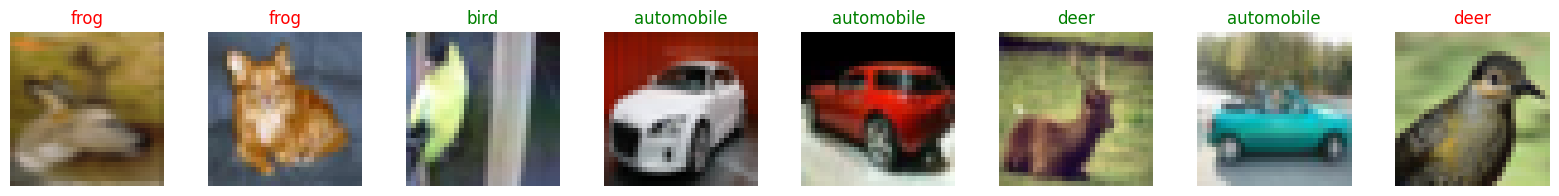

Training Epoch: 1
Training


100%|██████████| 664/664 [01:46<00:00,  6.24it/s]


Training Loss: 1.91 Training Accuracy: 0.42
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.52it/s]


Validation Loss: 1.9 Validation Accuracy: 0.42


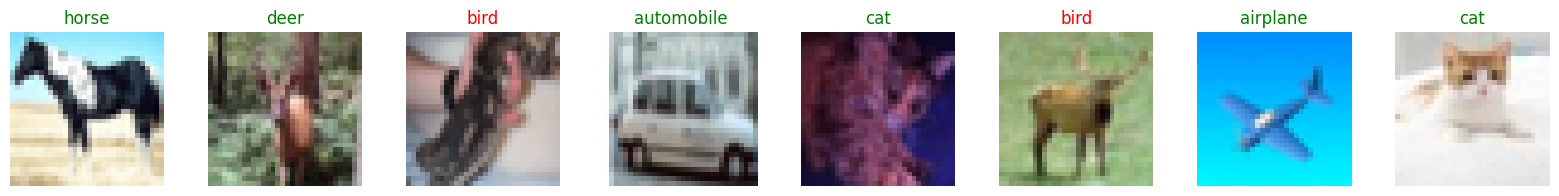

Training Epoch: 2
Training


100%|██████████| 664/664 [01:47<00:00,  6.19it/s]


Training Loss: 1.88 Training Accuracy: 0.45
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.61it/s]


Validation Loss: 1.88 Validation Accuracy: 0.48


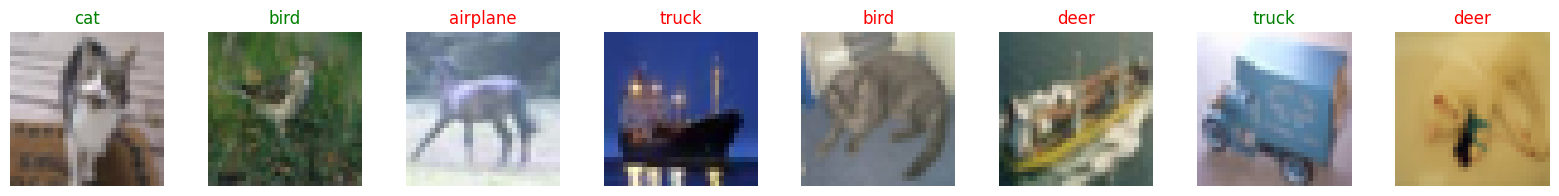

Training Epoch: 3
Training


100%|██████████| 664/664 [01:47<00:00,  6.19it/s]


Training Loss: 1.86 Training Accuracy: 0.47
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.33it/s]


Validation Loss: 1.86 Validation Accuracy: 0.46


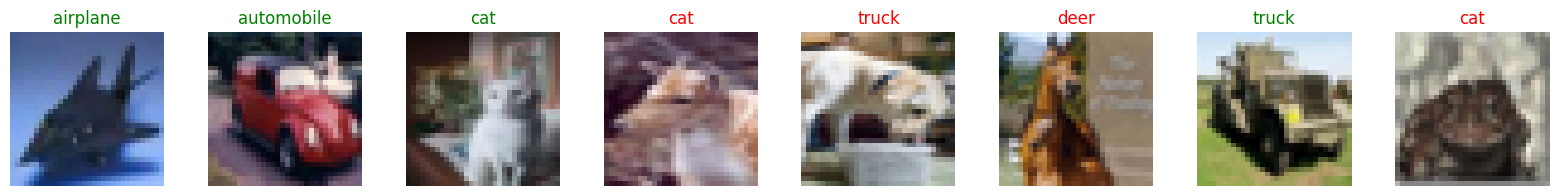

Training Epoch: 4
Training


100%|██████████| 664/664 [01:47<00:00,  6.17it/s]


Training Loss: 1.84 Training Accuracy: 0.48
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Validation Loss: 1.85 Validation Accuracy: 0.49


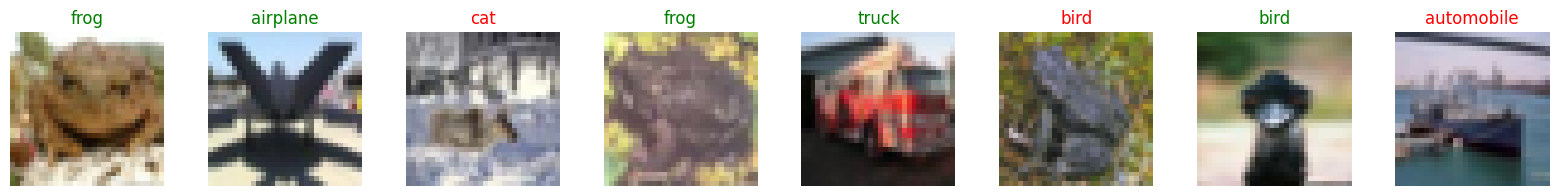

Training Epoch: 5
Training


100%|██████████| 664/664 [01:47<00:00,  6.17it/s]


Training Loss: 1.83 Training Accuracy: 0.5
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.49it/s]


Validation Loss: 1.84 Validation Accuracy: 0.5


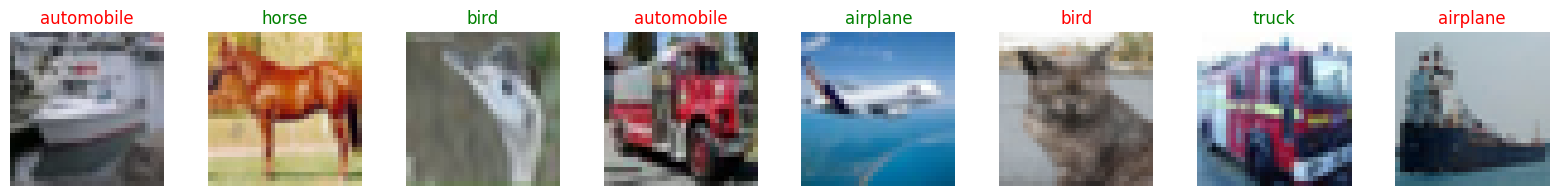

Training Epoch: 6
Training


100%|██████████| 664/664 [01:46<00:00,  6.21it/s]


Training Loss: 1.82 Training Accuracy: 0.51
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.55it/s]


Validation Loss: 1.84 Validation Accuracy: 0.51


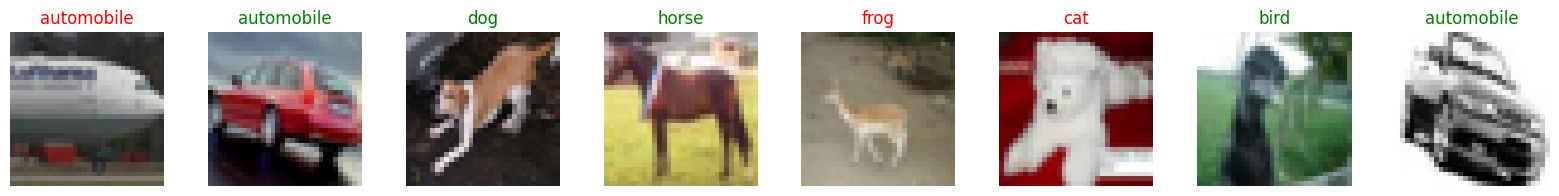

Training Epoch: 7
Training


100%|██████████| 664/664 [01:47<00:00,  6.16it/s]


Training Loss: 1.82 Training Accuracy: 0.52
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.54it/s]


Validation Loss: 1.84 Validation Accuracy: 0.52


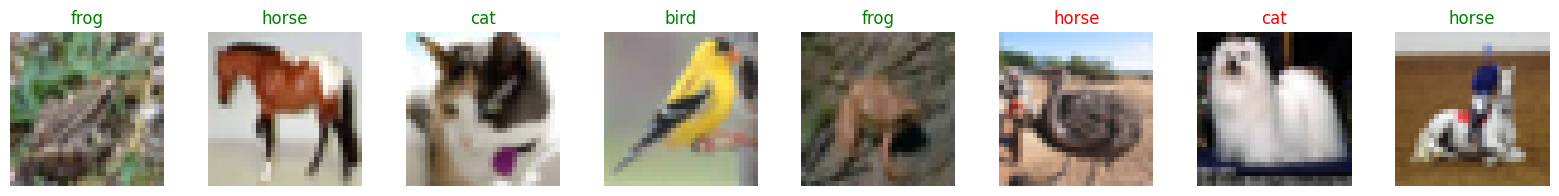

Training Epoch: 8
Training


100%|██████████| 664/664 [01:47<00:00,  6.16it/s]


Training Loss: 1.81 Training Accuracy: 0.53
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Validation Loss: 1.83 Validation Accuracy: 0.53


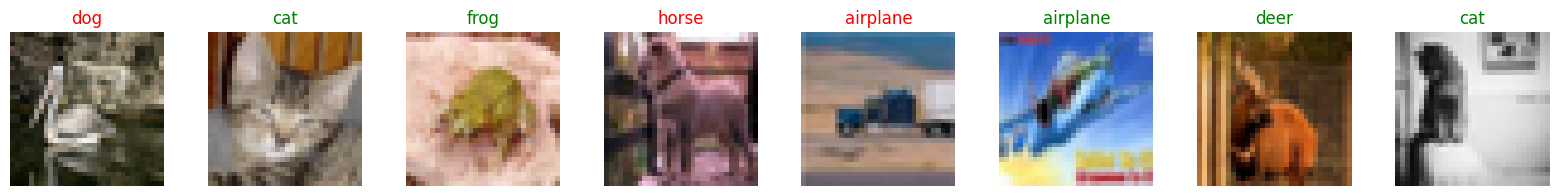

Training Epoch: 9
Training


100%|██████████| 664/664 [01:47<00:00,  6.17it/s]


Training Loss: 1.8 Training Accuracy: 0.54
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Validation Loss: 1.83 Validation Accuracy: 0.52


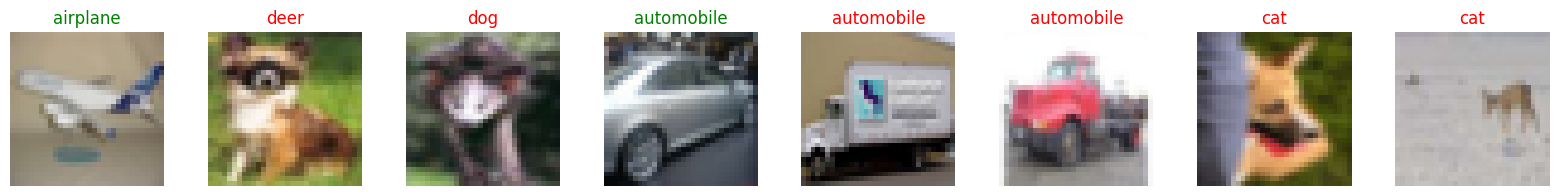

Training Epoch: 10
Training


100%|██████████| 664/664 [01:47<00:00,  6.17it/s]


Training Loss: 1.8 Training Accuracy: 0.54
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.51it/s]


Validation Loss: 1.83 Validation Accuracy: 0.53


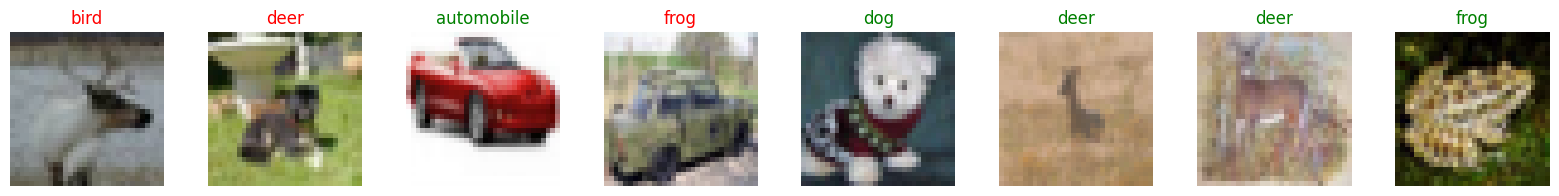

Training Epoch: 11
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.8 Training Accuracy: 0.55
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Validation Loss: 1.82 Validation Accuracy: 0.52


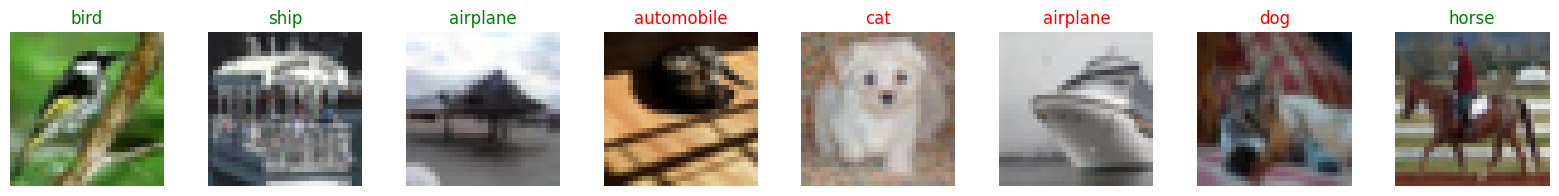

Training Epoch: 12
Training


100%|██████████| 664/664 [01:47<00:00,  6.15it/s]


Training Loss: 1.79 Training Accuracy: 0.56
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.33it/s]


Validation Loss: 1.82 Validation Accuracy: 0.53


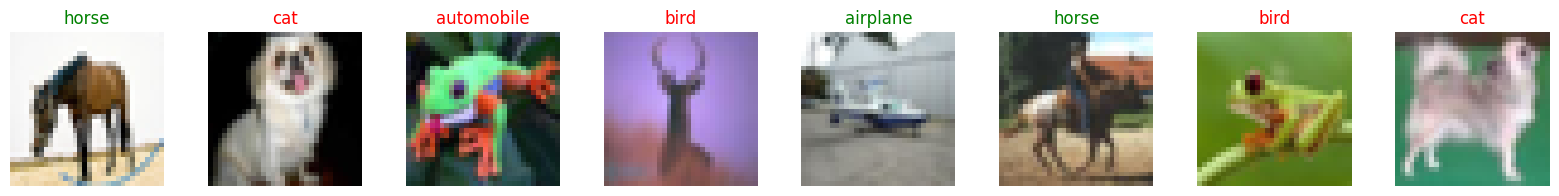

Training Epoch: 13
Training


100%|██████████| 664/664 [01:47<00:00,  6.19it/s]


Training Loss: 1.79 Training Accuracy: 0.56
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Validation Loss: 1.82 Validation Accuracy: 0.54


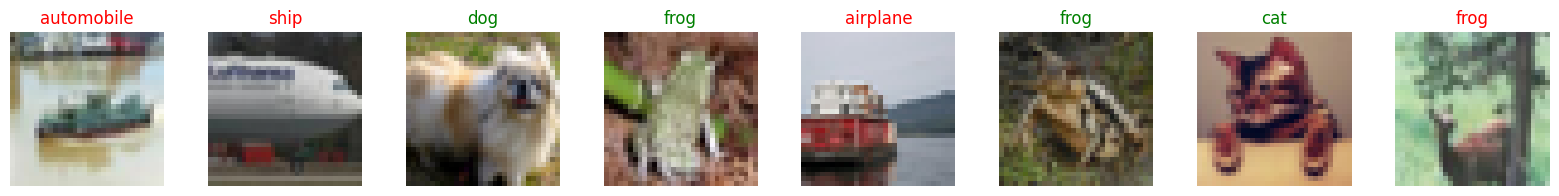

Training Epoch: 14
Training


100%|██████████| 664/664 [01:47<00:00,  6.15it/s]


Training Loss: 1.78 Training Accuracy: 0.57
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Validation Loss: 1.82 Validation Accuracy: 0.55


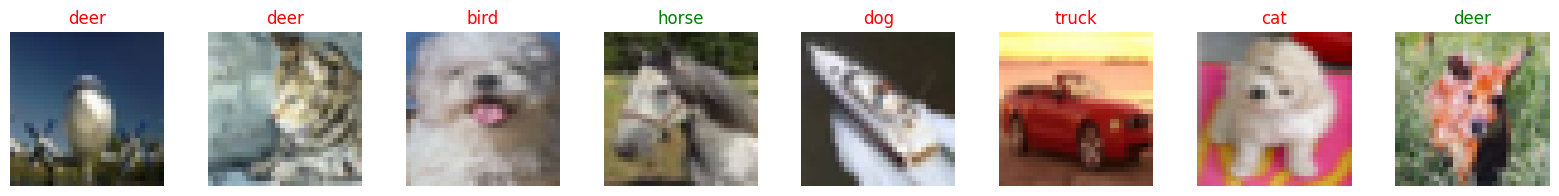

Training Epoch: 15
Training


100%|██████████| 664/664 [01:47<00:00,  6.17it/s]


Training Loss: 1.78 Training Accuracy: 0.57
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.37it/s]


Validation Loss: 1.81 Validation Accuracy: 0.56


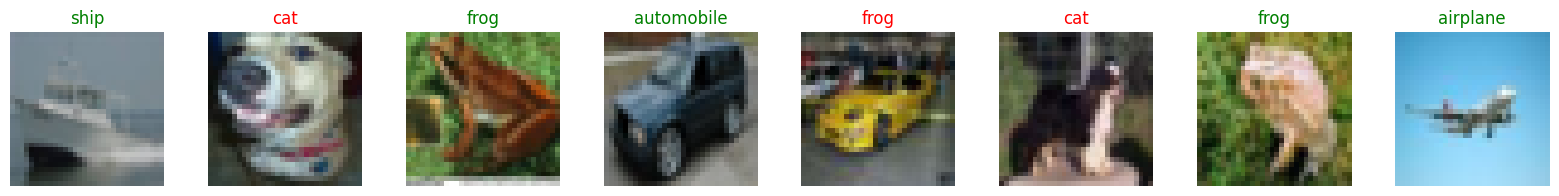

Training Epoch: 16
Training


100%|██████████| 664/664 [01:47<00:00,  6.15it/s]


Training Loss: 1.78 Training Accuracy: 0.58
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.38it/s]


Validation Loss: 1.81 Validation Accuracy: 0.55


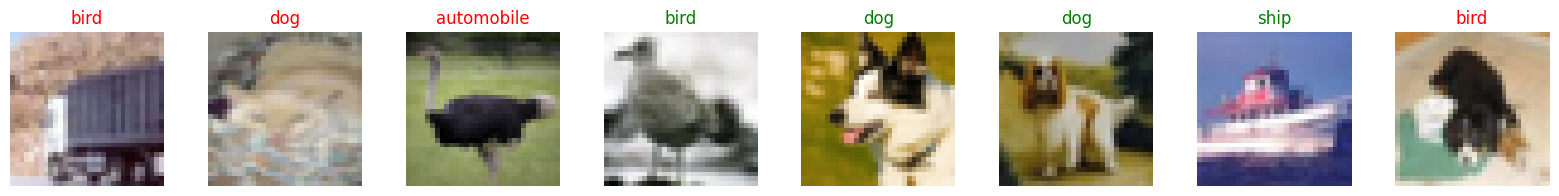

Training Epoch: 17
Training


100%|██████████| 664/664 [01:48<00:00,  6.14it/s]


Training Loss: 1.78 Training Accuracy: 0.58
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Validation Loss: 1.81 Validation Accuracy: 0.54


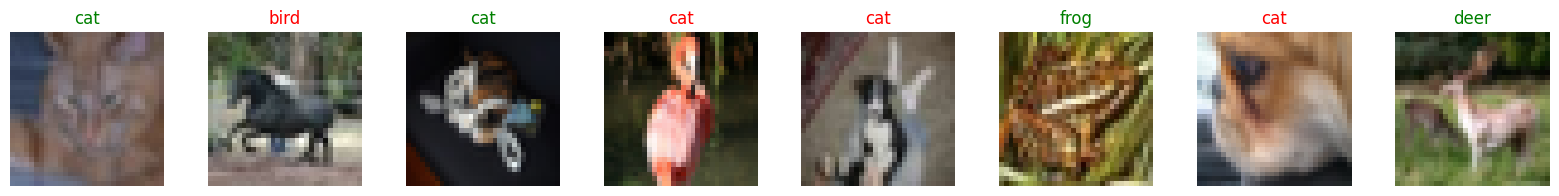

Training Epoch: 18
Training


100%|██████████| 664/664 [01:48<00:00,  6.14it/s]


Training Loss: 1.77 Training Accuracy: 0.58
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Validation Loss: 1.81 Validation Accuracy: 0.57


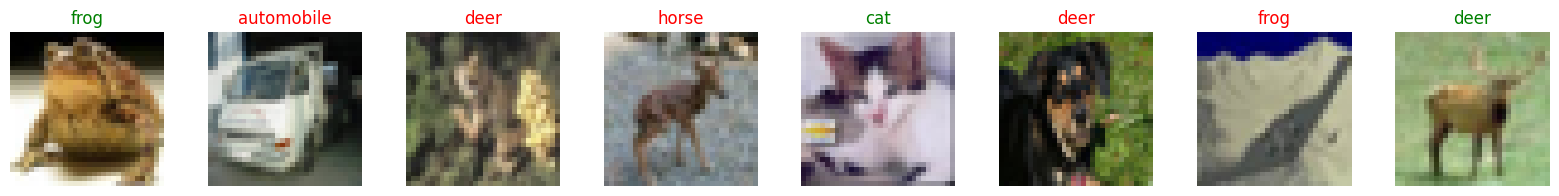

Training Epoch: 19
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.77 Training Accuracy: 0.59
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Validation Loss: 1.81 Validation Accuracy: 0.56


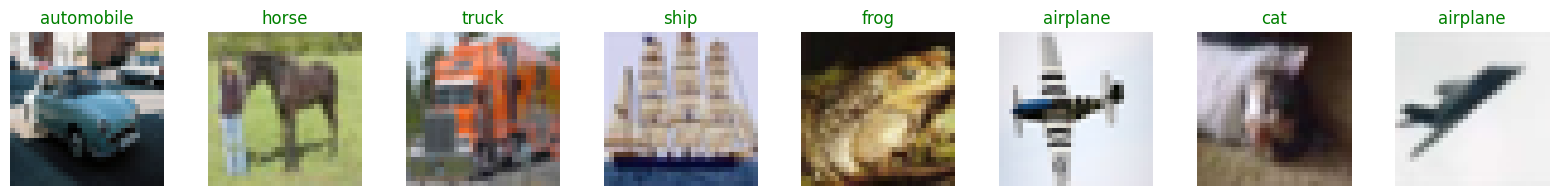

Training Epoch: 20
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.77 Training Accuracy: 0.59
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.37it/s]


Validation Loss: 1.81 Validation Accuracy: 0.57


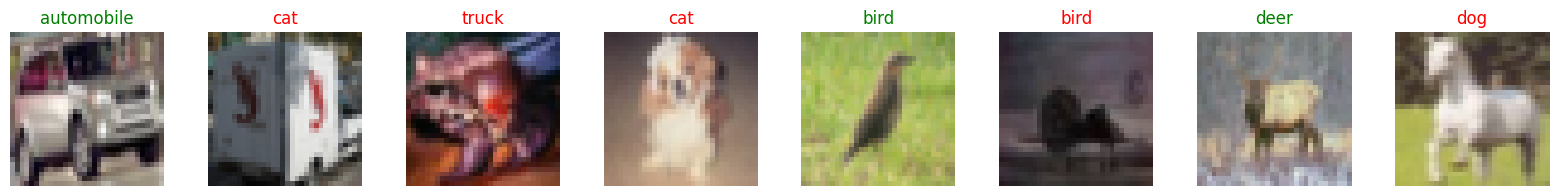

Training Epoch: 21
Training


100%|██████████| 664/664 [01:47<00:00,  6.15it/s]


Training Loss: 1.77 Training Accuracy: 0.59
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Validation Loss: 1.81 Validation Accuracy: 0.56


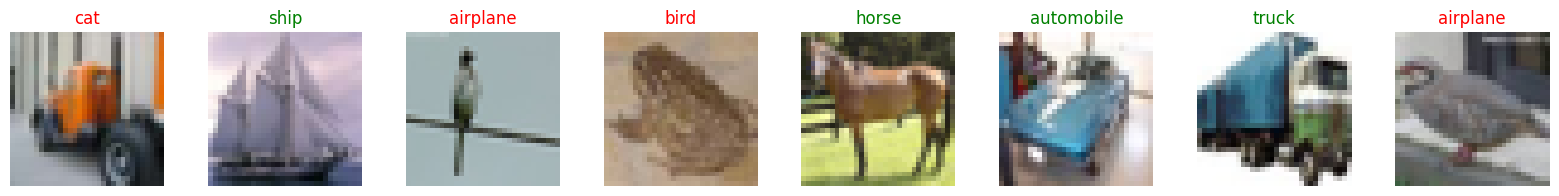

Training Epoch: 22
Training


100%|██████████| 664/664 [01:47<00:00,  6.16it/s]


Training Loss: 1.77 Training Accuracy: 0.6
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Validation Loss: 1.81 Validation Accuracy: 0.57


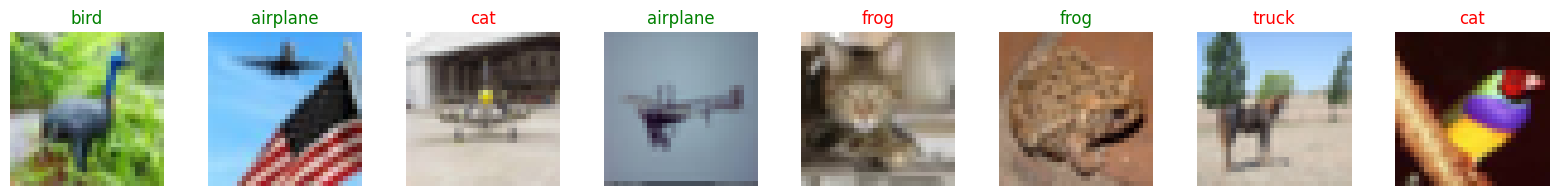

Training Epoch: 23
Training


100%|██████████| 664/664 [01:48<00:00,  6.14it/s]


Training Loss: 1.77 Training Accuracy: 0.6
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Validation Loss: 1.81 Validation Accuracy: 0.57


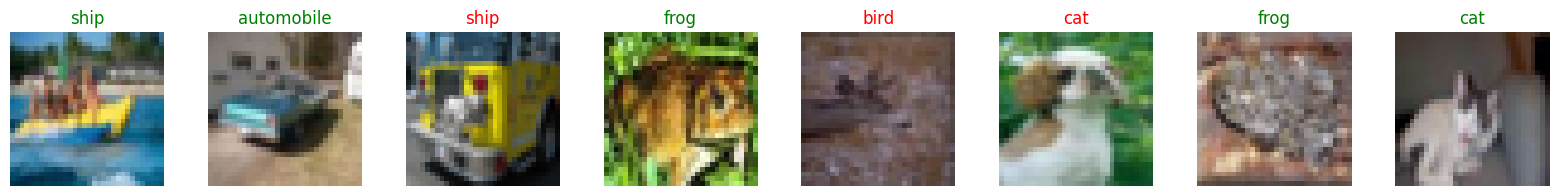

Training Epoch: 24
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.76 Training Accuracy: 0.6
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.28it/s]


Validation Loss: 1.8 Validation Accuracy: 0.58


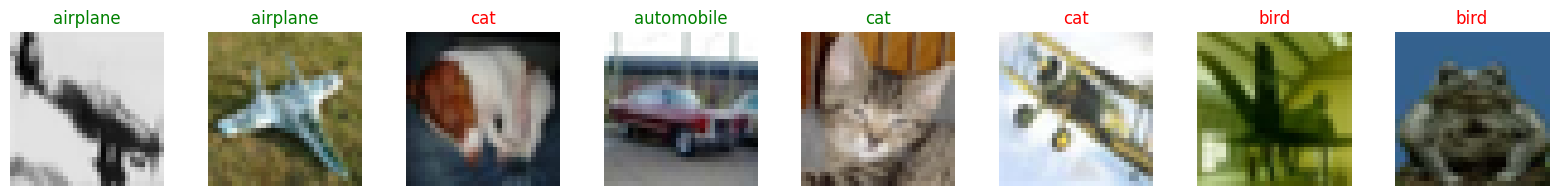

Training Epoch: 25
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.76 Training Accuracy: 0.6
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Validation Loss: 1.8 Validation Accuracy: 0.57


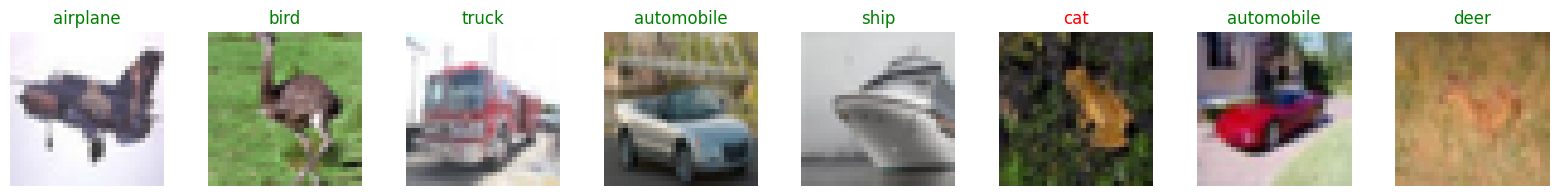

Training Epoch: 26
Training


100%|██████████| 664/664 [01:48<00:00,  6.10it/s]


Training Loss: 1.76 Training Accuracy: 0.6
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.35it/s]


Validation Loss: 1.8 Validation Accuracy: 0.57


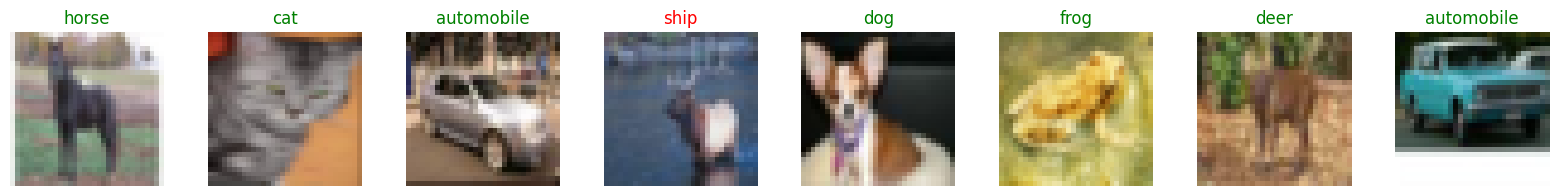

Training Epoch: 27
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.76 Training Accuracy: 0.61
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Validation Loss: 1.8 Validation Accuracy: 0.57


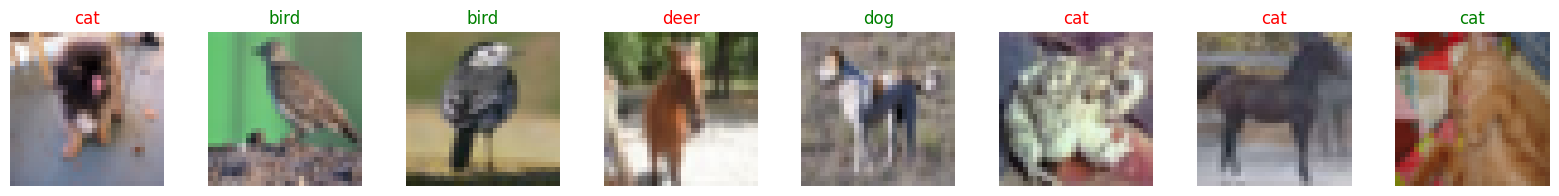

Training Epoch: 28
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.76 Training Accuracy: 0.61
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.26it/s]


Validation Loss: 1.8 Validation Accuracy: 0.57


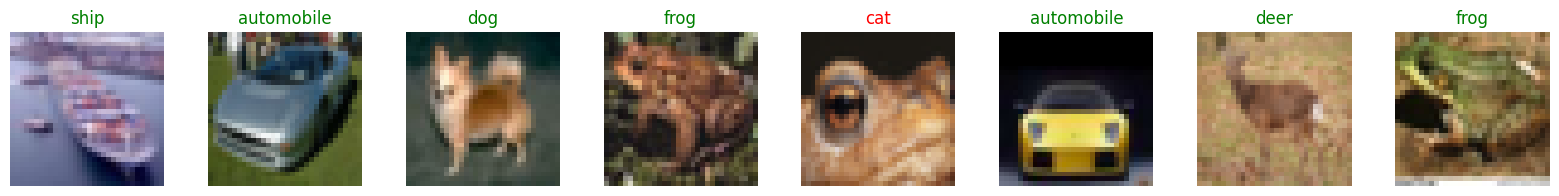

Training Epoch: 29
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.76 Training Accuracy: 0.61
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Validation Loss: 1.8 Validation Accuracy: 0.58


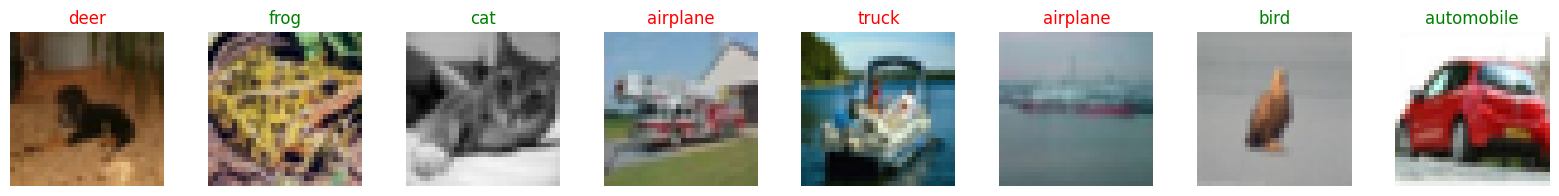

Training Epoch: 30
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.76 Training Accuracy: 0.61
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Validation Loss: 1.8 Validation Accuracy: 0.57


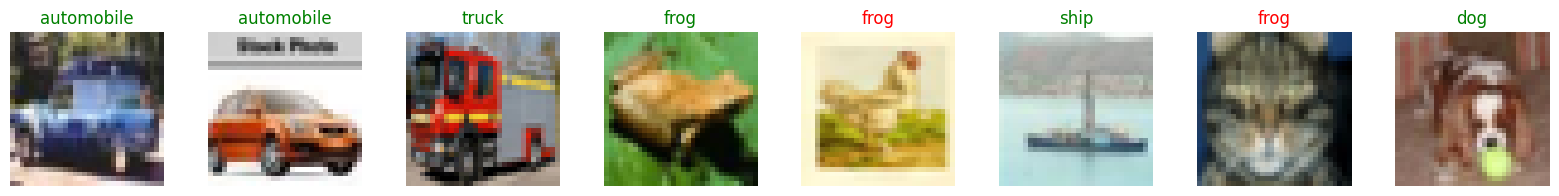

Training Epoch: 31
Training


100%|██████████| 664/664 [01:48<00:00,  6.10it/s]


Training Loss: 1.76 Training Accuracy: 0.61
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.32it/s]


Validation Loss: 1.8 Validation Accuracy: 0.58


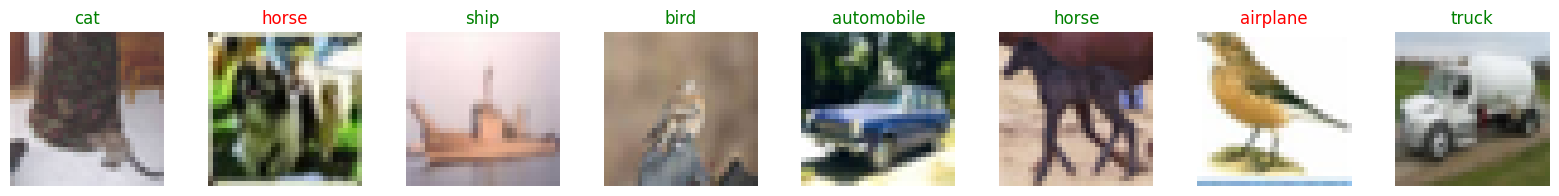

Training Epoch: 32
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.25it/s]


Validation Loss: 1.8 Validation Accuracy: 0.57


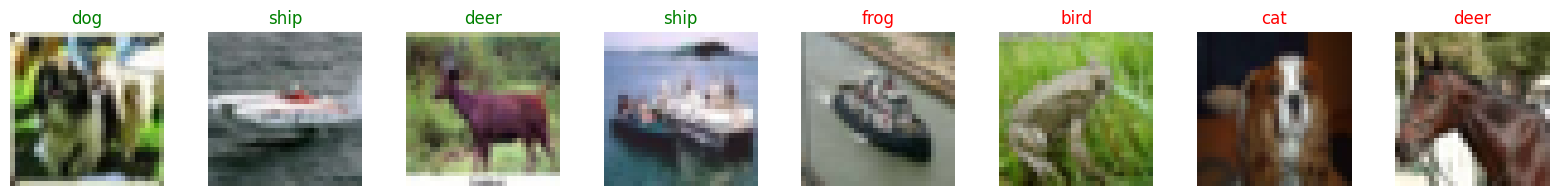

Training Epoch: 33
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.34it/s]


Validation Loss: 1.8 Validation Accuracy: 0.58


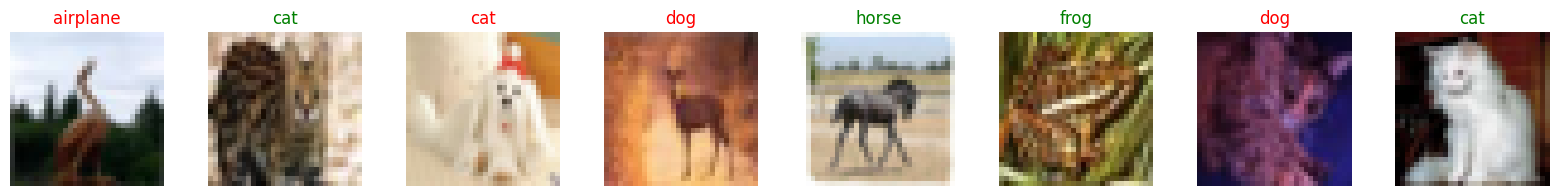

Training Epoch: 34
Training


100%|██████████| 664/664 [01:48<00:00,  6.10it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.27it/s]


Validation Loss: 1.79 Validation Accuracy: 0.58


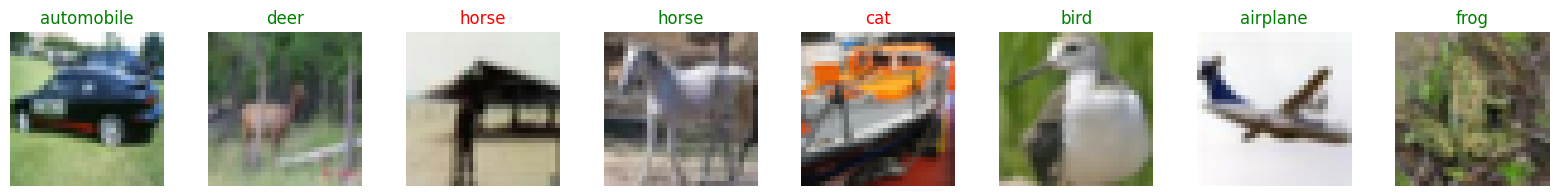

Training Epoch: 35
Training


100%|██████████| 664/664 [01:49<00:00,  6.08it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.40it/s]


Validation Loss: 1.8 Validation Accuracy: 0.59


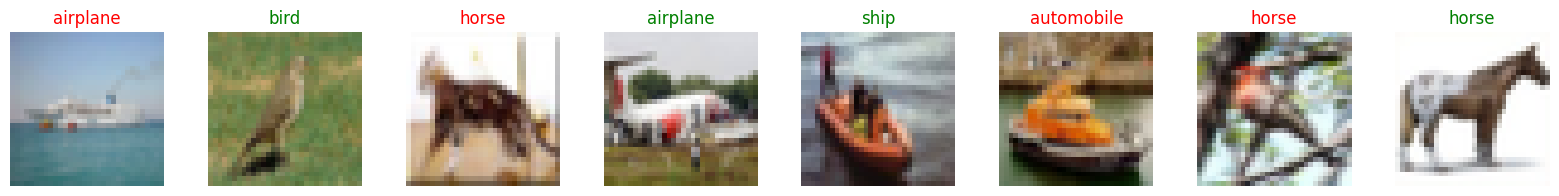

Training Epoch: 36
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.14it/s]


Validation Loss: 1.79 Validation Accuracy: 0.57


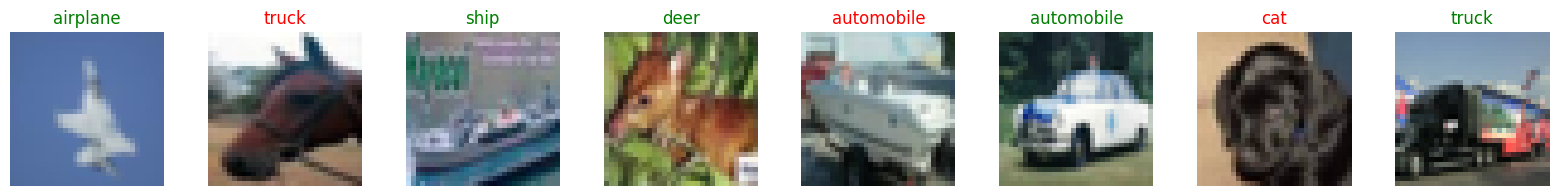

Training Epoch: 37
Training


100%|██████████| 664/664 [01:48<00:00,  6.11it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.26it/s]


Validation Loss: 1.8 Validation Accuracy: 0.59


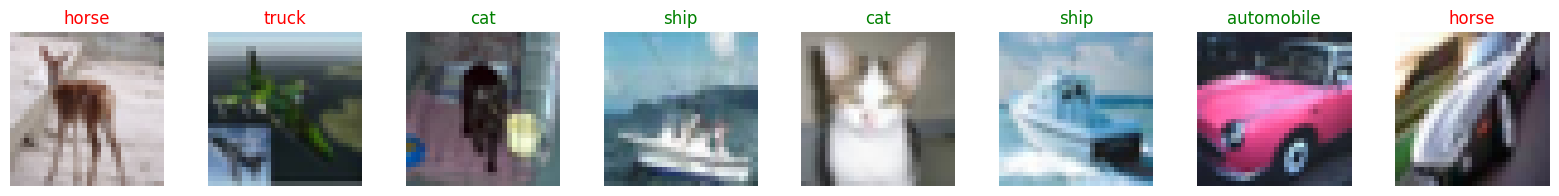

Training Epoch: 38
Training


100%|██████████| 664/664 [01:48<00:00,  6.11it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Validation Loss: 1.79 Validation Accuracy: 0.59


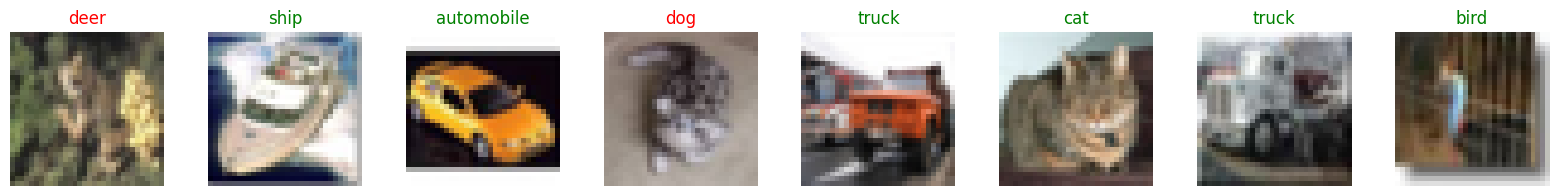

Training Epoch: 39
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.75 Training Accuracy: 0.62
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.37it/s]


Validation Loss: 1.79 Validation Accuracy: 0.58


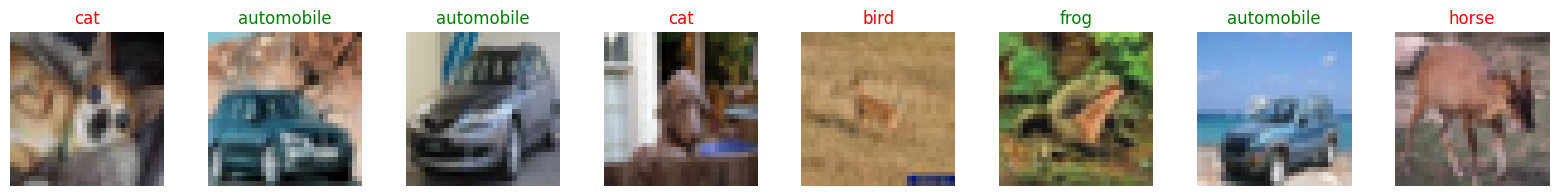

Training Epoch: 40
Training


100%|██████████| 664/664 [01:48<00:00,  6.11it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.19it/s]


Validation Loss: 1.79 Validation Accuracy: 0.57


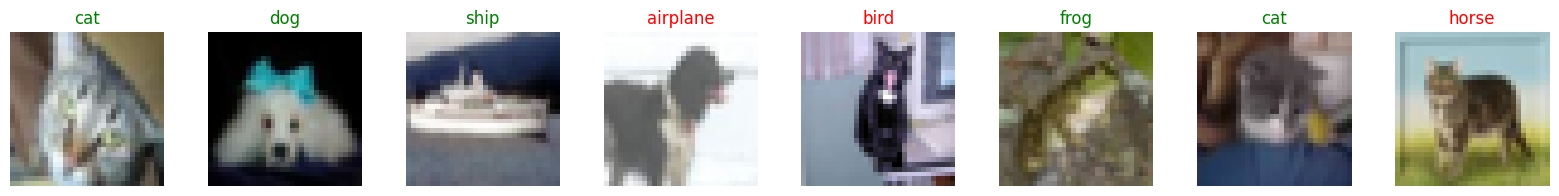

Training Epoch: 41
Training


100%|██████████| 664/664 [01:48<00:00,  6.11it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.22it/s]


Validation Loss: 1.79 Validation Accuracy: 0.59


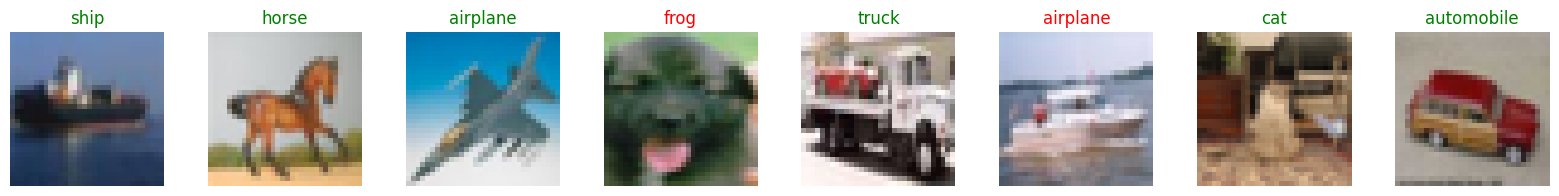

Training Epoch: 42
Training


100%|██████████| 664/664 [01:48<00:00,  6.10it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.38it/s]


Validation Loss: 1.79 Validation Accuracy: 0.59


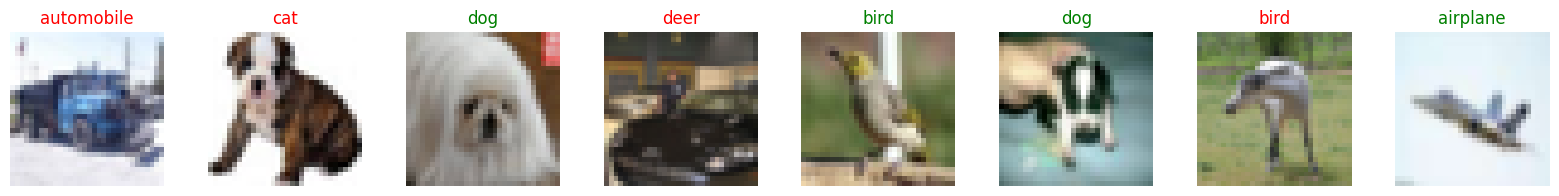

Training Epoch: 43
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Validation Loss: 1.79 Validation Accuracy: 0.59


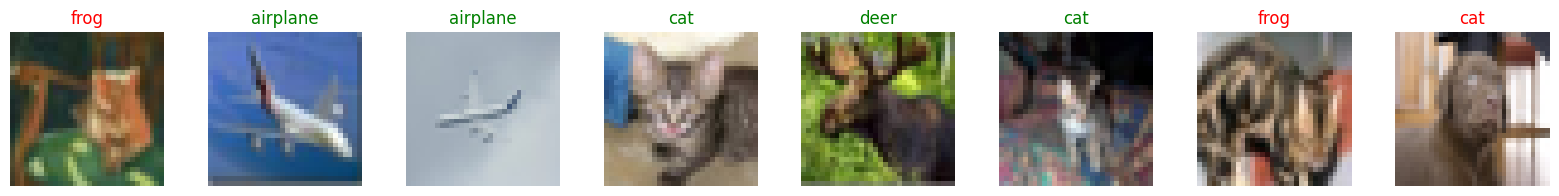

Training Epoch: 44
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.19it/s]


Validation Loss: 1.79 Validation Accuracy: 0.6


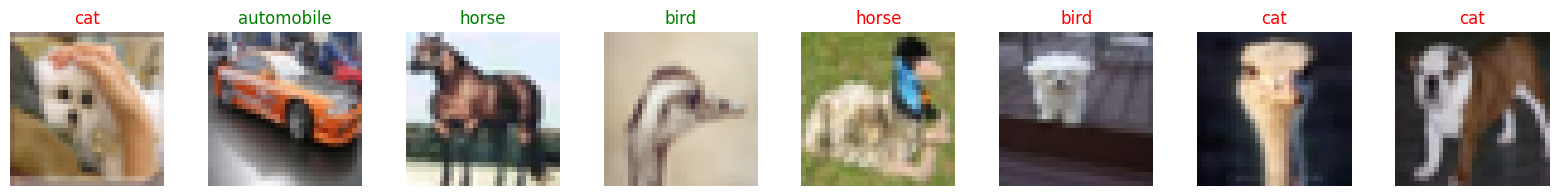

Training Epoch: 45
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Validation Loss: 1.79 Validation Accuracy: 0.58


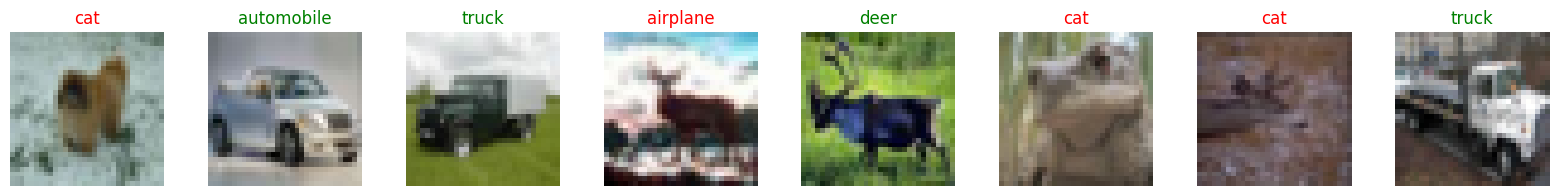

Training Epoch: 46
Training


100%|██████████| 664/664 [01:48<00:00,  6.13it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Validation Loss: 1.79 Validation Accuracy: 0.59


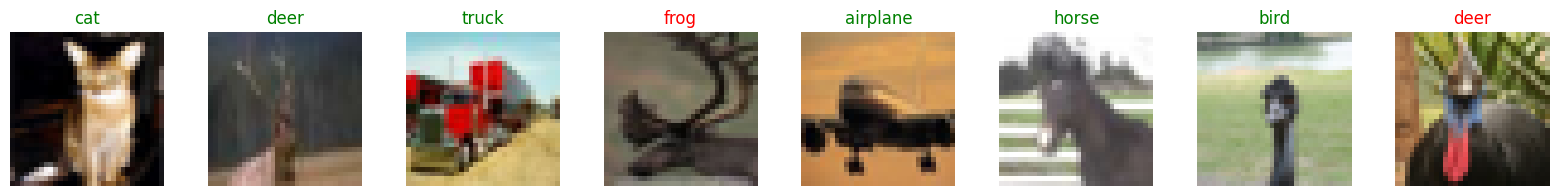

Training Epoch: 47
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Validation Loss: 1.78 Validation Accuracy: 0.59


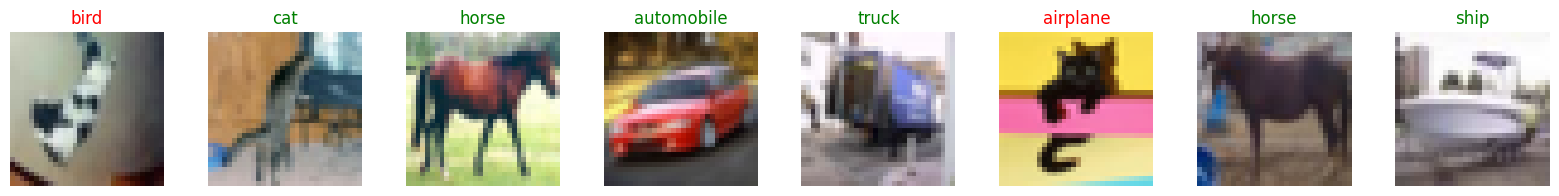

Training Epoch: 48
Training


100%|██████████| 664/664 [01:48<00:00,  6.12it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.19it/s]


Validation Loss: 1.79 Validation Accuracy: 0.6


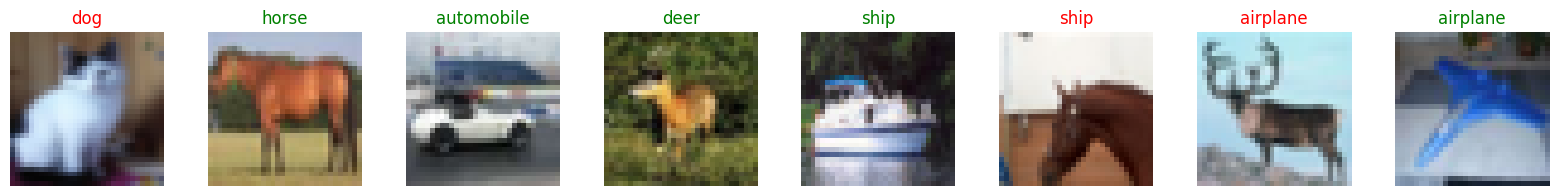

Training Epoch: 49
Training


100%|██████████| 664/664 [01:49<00:00,  6.09it/s]


Training Loss: 1.74 Training Accuracy: 0.63
Evaluating


100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Validation Loss: 1.79 Validation Accuracy: 0.6


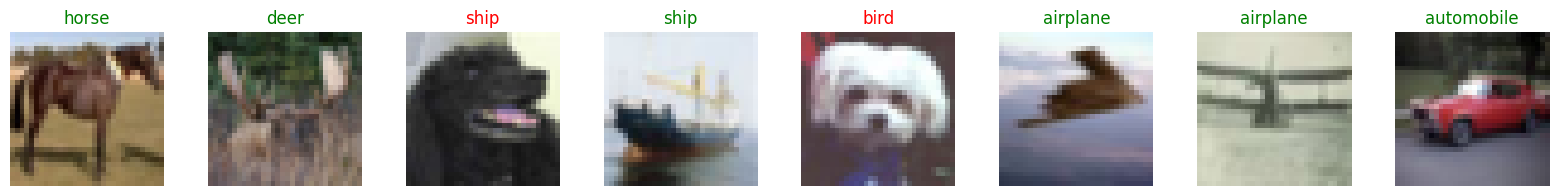

100%|██████████| 156/156 [00:16<00:00,  9.34it/s]

Testing Loss: 1.79 Testing Accuracy: 0.59


In [17]:
classifier, train_total_loss, train_total_accuracy, val_total_loss, val_total_accuracy, test_loss, test_acc = train(epochs = EPOCHS, data_loader = train_loader,
                                               val_loader = val_loader, test_loader = test_loader, classifier = classifier,
                                               optimizer = optimizer, loss_fn = SF.ce_rate_loss(), device = device)

In [18]:
new_weights = retrieve_weights(classifier)
compare_weights(initial_weights, new_weights)

weights have been updated.


## Saving the Model

In [19]:
torch.save(classifier.state_dict(), 'SNN_Model.pth')

## Visualizations

This section is concerned with visualizations of model's performance, 3 visualizations have been presented. The first one showcases the decrease in loss and increase in the accuracy during the training process for both training and validation sets. Next visualization showcases the neurons for which the weights have changed the most, testing if some neurons are crucial for the working of our network. Lastly, an animation showing the firing process of neurons has been displayed.

### Functions

In [20]:
def visualize_weight_changes(initial_weights, new_weights, layer_name):
    if len(initial_weights.shape) > 2:
        initial_reshaped_tensor = initial_weights.reshape(initial_weights.shape[0], -1)
        new_reshaped_tensor = new_weights.reshape(initial_weights.shape[0], -1)
    else:
        initial_reshaped_tensor = initial_weights
        new_reshaped_tensor = new_weights
    weight_diff = torch.abs(new_reshaped_tensor - initial_reshaped_tensor).detach().cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(weight_diff, cmap="viridis", annot=False, cbar=True)
    plt.title(f"Weight Changes in {layer_name}")
    plt.xlabel("Weights")
    plt.ylabel("Neurons")
    plt.show()

In [21]:
def animate_spikes_and_potential(spk_rec, mem_rec):
    spk_rec = spk_rec.detach()
    mem_rec = mem_rec.detach()
    num_steps, batch_size, num_classes = spk_rec.shape
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    def update(step):
        ax1.clear()
        ax2.clear()

        ax1.imshow(spk_rec[step].cpu().numpy(), aspect='auto', cmap='gray_r')
        ax1.set_title(f'Spike Activity at Step {step + 1}')
        ax1.set_ylabel('Neurons')

        ax2.imshow(mem_rec[step].cpu().numpy(), aspect='auto', cmap='viridis')
        ax2.set_title(f'Membrane Potential at Step {step + 1}')
        ax2.set_ylabel('Neurons')
        ax2.set_xlabel('Examples')

    ani = FuncAnimation(fig, update, frames=num_steps, repeat=False)
    plt.tight_layout()
    return ani

In [22]:
def plot_training_process(train_total_loss, train_total_accuracy, val_total_loss, val_total_accuracy):
    epochs = range(1, len(train_total_loss) + 1)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_total_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_total_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_total_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_total_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Running Code

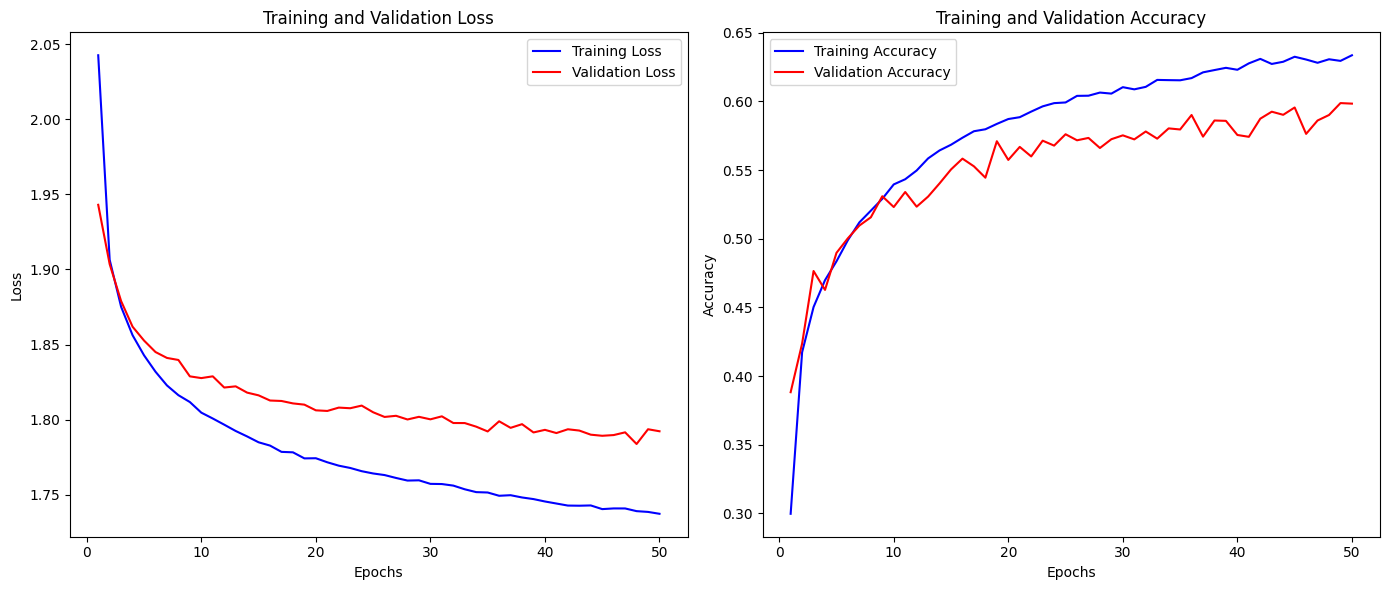

In [23]:
plot_training_process(train_total_loss, train_total_accuracy, val_total_loss, val_total_accuracy)

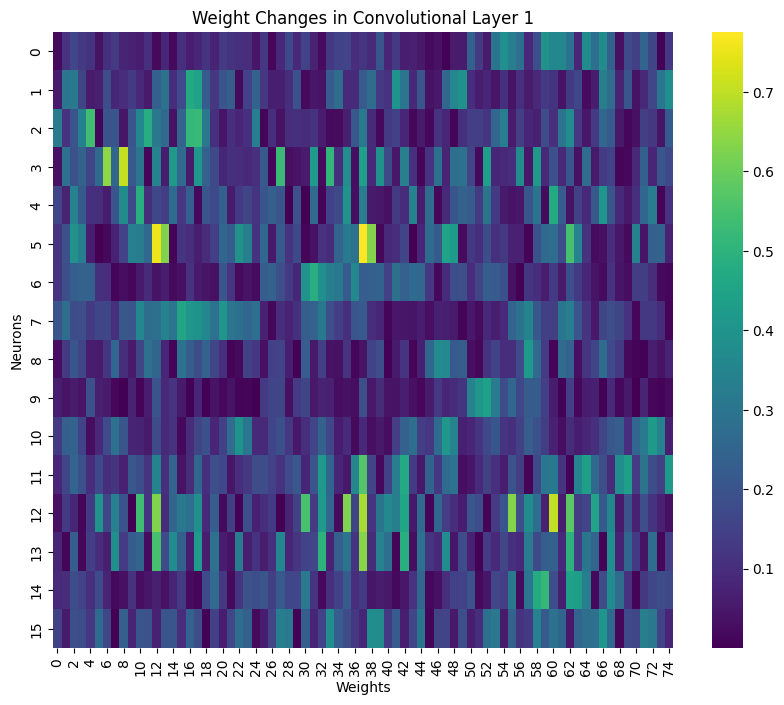

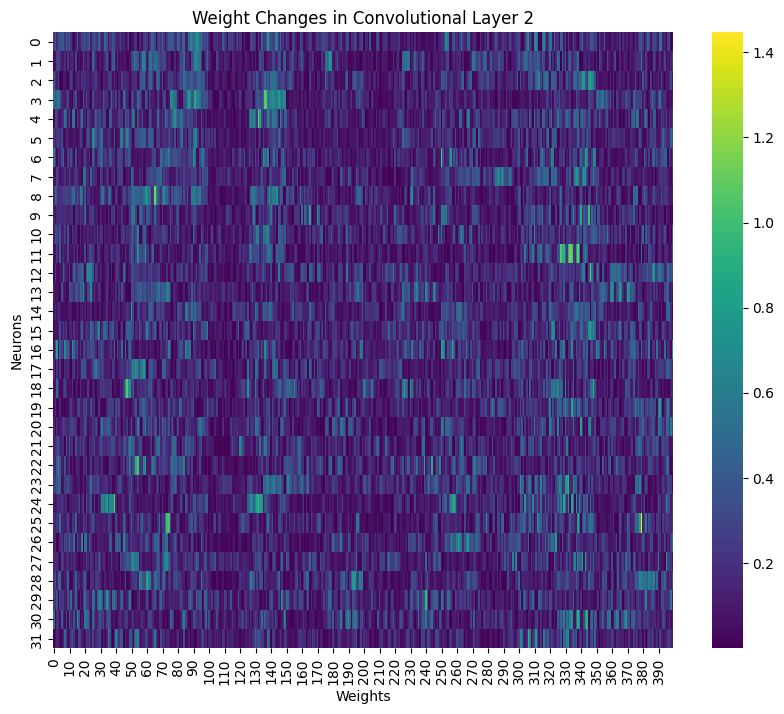

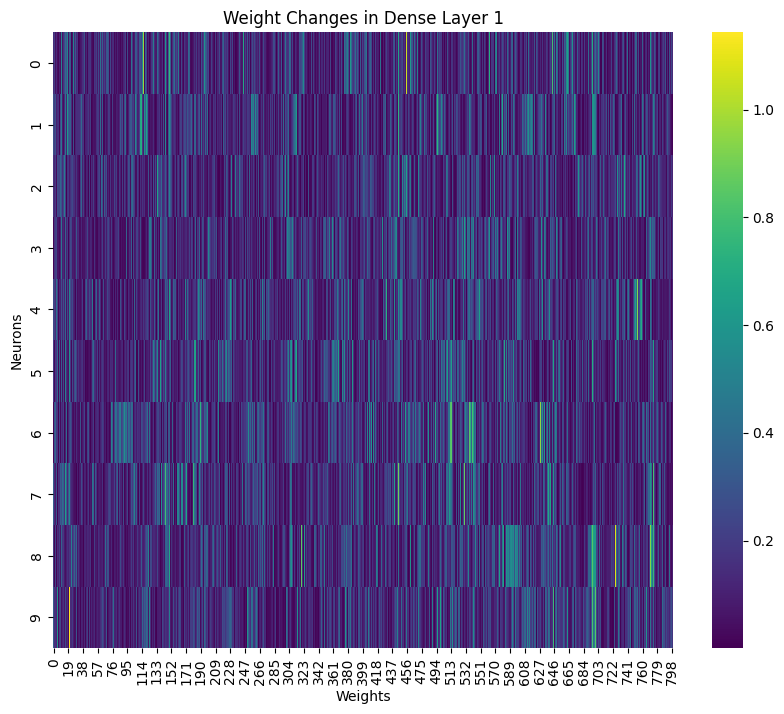

In [24]:
visualize_weight_changes(initial_weights['conv1.weight'], new_weights['conv1.weight'], 'Convolutional Layer 1')
visualize_weight_changes(initial_weights['conv2.weight'], new_weights['conv2.weight'], 'Convolutional Layer 2')
visualize_weight_changes(initial_weights['fc1.weight'], new_weights['fc1.weight'], 'Dense Layer 1')

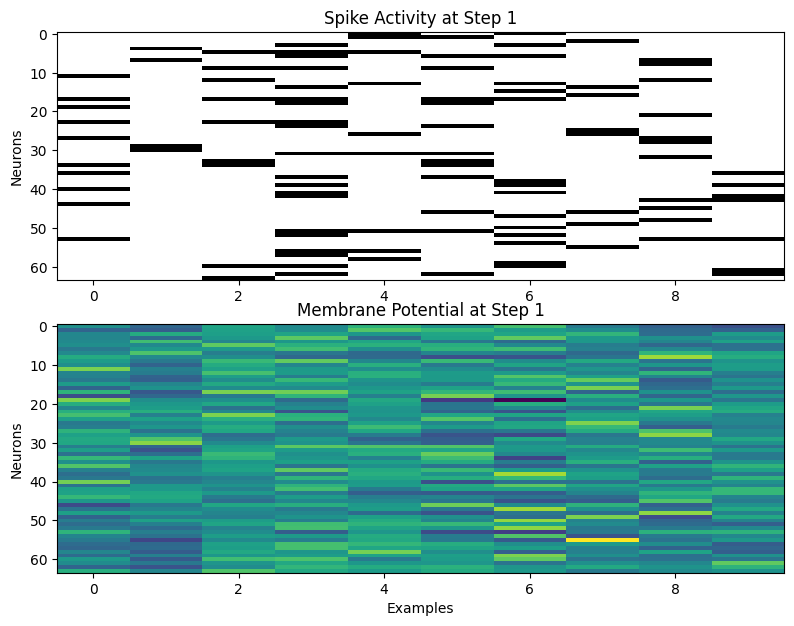

In [25]:
for images, labels in val_loader:
    images = images.to(device)
    spk_rec, mem_rec = classifier(images)
    break
ani = animate_spikes_and_potential(spk_rec, mem_rec)
video_path = "model_response_animation.mp4"
ani.save(video_path)
vid = Video(video_path, embed=True)

In [26]:
vid